# Jaylen Hicks
## Final Analysis Plan
### Hypothesis: Cancel culture has been prominent in the last couple of decades, when a celebrity acts in an unacceptable manner, they are shunned. I want to take a list of YouTubers and track their engagement after a boycott of their content has been called to see if cancel culture is effective, or if public relations teams can navigate through the controversy. For this, I will use Youtube's API as my potential data source. I believe that that data will show that after a while, people forget about the conntroversy, and continue to support the creator after their apology video.

#### Reference https://www.youtube.com/watch?v=2mSwcRb3KjQ I used this video as a reference to help guide me through the Youtube API in completing this report

I looked at five Youtube Accounts from diverent genres: One talk show host, one major gamers, a oscar award winning actor, one Netflix creator, and one boxer. I looked at 10 videos before their apology video, and ten videos after their apology video to track their viewership. I also looked at likes and other metric data to see if the public approved or disapproved of their content after their shunning.

In [109]:
import requests
import base64
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build 
import json
secrets_filename = 'API_KEY.txt'
api_keys = {}
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [114]:
ellen_id = "UCp0hYYBW6IMayGgR-WeoCvQ"
colleen_id = "UCrbSjN1_5U7hqFKRA0nvFXQ"
logan_id = "UCG8rbF3g2AMX70yOd8vqIZg"
will_id = "UCKuHFYu3smtrl2AwwMOXOlg"
pew_id = "UC-lHJZR3Gqxm24_Vd_AJ5Yw"

Here are the channel IDs for each of the Five Channels. If we plug in the channel ID to the function below, we can change which canceled channel's data to analyze.

In [115]:
channel_id = "UCrbSjN1_5U7hqFKRA0nvFXQ"

This is defining a new function that getst the stats from the channel. It uses the Part section of the API, which is the only required input to retrieve data.

In [116]:
def get_channel_stats(youtube, channel_id):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()
    
    return response['items']

In [117]:
channel_stats = get_channel_stats(youtube, channel_id)

This is creating a new variable that get the channel stats from the given channel ID.

In [118]:
playlist_id = channel_stats[0]['contentDetails']

This is using the content Details component of the Youtube API to give the facts about each video.

In [119]:
def get_video_list(youtube, upload_id):
    video_list = []
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=upload_id,
        maxResults=50
    )
    next_page = True
    while next_page:
        response = request.execute()
        data = response['items']

        for video in data:
            video_id = video['contentDetails']['videoId']
            if video_id not in video_list:
                video_list.append(video_id)

        if 'nextPageToken' in response.keys():
            next_page = True
            request = youtube.playlistItems().list(
                part="snippet,contentDetails",
                playlistId=upload_id,
                pageToken=response['nextPageToken'],
                maxResults=50
            )
        else:
            next_page = False

    return video_list

Get Video List makes turns the content of th the chanels into an array that makes it easier for analysis. The next page token section is a method to see more than the 50th item in the list.

In [120]:
channel_stats = get_channel_stats(youtube, channel_id)

In [121]:
playlist_id = channel_stats[0]['contentDetails']['relatedPlaylists']['uploads']
playlist_id

'UUrbSjN1_5U7hqFKRA0nvFXQ'

Get video details his a loop function that helps give information for each videa that the content creator has releases. This request will give infomromation about each video's Title, Publisuh date, view and like count etc.

In [122]:
video_list = get_video_list(youtube, playlist_id)

In [78]:
def get_video_details(youtube, video_list):
    stats_list=[]

    for i in range(0, len(video_list), 50):
        request= youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=video_list[i:i+50]
        )

        data = request.execute()
        for video in data['items']:
            title=video['snippet']['title']
            published=video['snippet']['publishedAt']
            description=video['snippet']['description']
            tag_count= len(video['snippet'].get('tags',[]))
            view_count=video['statistics'].get('viewCount',0)
            like_count=video['statistics'].get('likeCount',0)
            dislike_count=video['statistics'].get('dislikeCount',0)
            comment_count=video['statistics'].get('commentCount',0)
            stats_dict=dict(title=title, description=description, published=published, tag_count=tag_count, view_count=view_count, like_count=like_count, dislike_count=dislike_count, comment_count=comment_count)
            stats_list.append(stats_dict)

    return stats_list

In [79]:
video_data = get_video_details(youtube, video_list)

In [80]:
df=pd.DataFrame(video_data)
df['title_length'] = df['title'].str.len()
df["view_count"] = pd.to_numeric(df["view_count"])
df["like_count"] = pd.to_numeric(df["like_count"])
df["dislike_count"] = pd.to_numeric(df["dislike_count"])
df["comment_count"] = pd.to_numeric(df["comment_count"])
# reaction used later add up likes + dislikes + comments
df["reactions"] = df["like_count"] + df["dislike_count"] + df["comment_count"] + df["comment_count"]
df.head()

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions
0,MARSHALLS HAUL! KIDS BIRTHDAY & CHRISTMAS PRES...,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-10T22:00:34Z,25,63400,4517,0,221,51,4959
1,Christmas Lights & Home Renovation Plans,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-08T22:10:18Z,22,97191,5547,0,384,40,6315
2,TIKTOK CHAMOY PICKLE TASTE TEST!,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-07T22:12:15Z,23,92553,5894,0,431,32,6756
3,I GOT SO MANY COMMENTS LIKE THIS! 😩,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-07T00:10:12Z,19,120521,6727,0,684,35,8095
4,TAYLOR SWIFT COPIED ME!,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-05T21:54:18Z,24,95598,6036,0,565,23,7166


This is the first Data frame of the analysis. It is displaying the video's metric data in a table. We can later convert this table to a graph for later analysis. These are the five most recent videos that were released by the canceled artist. We can see the large difference between the number of likes on the video and the number of views that thi creator can still bring in.

/var/folders/g3/ctc6z5_92z94rwldl4h6plmw0000gn/T/ipykernel_13903/404705914.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  chart = sns.distplot( a=df["tag_count"], hist=True, kde=False, rug=False )


[Text(0.5, 0, 'Number of Tags Used'), Text(0, 0.5, 'Occurrences')]

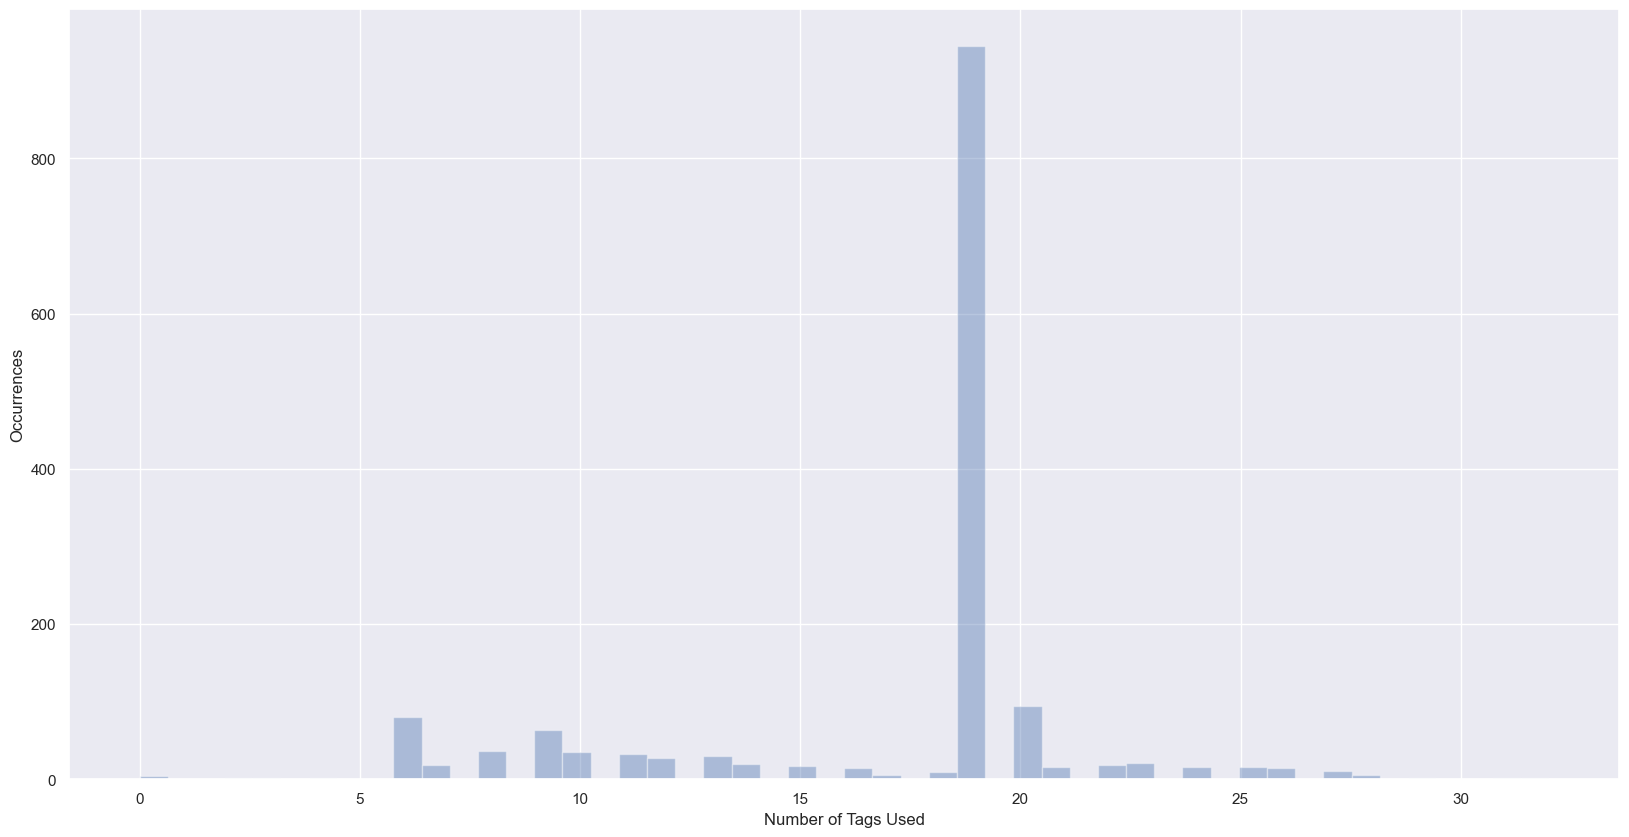

In [99]:
chart = sns.distplot( a=df["tag_count"], hist=True, kde=False, rug=False )
chart.set(xlabel='Number of Tags Used', ylabel='Occurrences')

This DataFrame i showing all. of the most popular videos that this creator made. In this instance of Colleen Ballinger, her most viewed vider is the very same video that got her canceled. The rest of her popular videos occured before she releaced the apoplogy video. Comparing her views, from 2018, where she was receiveing millions of views per video, now she receives appox. 100k views per video. This shows that her channel has seen a significant decrease in viewership, and even less engaging in the conversations on her page. However, her metric data is trending back up as time move further from her "Hi" video.

In [82]:
df_highest_views = df.nlargest(10, 'view_count')
df_highest_views['title'] = df_highest_views['title'].str[:40]
df_highest_views['view_count_millions'] = df_highest_views['view_count'] / 1000000
df_highest_views

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions,view_count_millions
20,hi.,I do not condone or support any kind of online...,2023-06-28T19:24:48Z,19,16732843,153728,0,13233,3,180194,16.732843
1113,Finding out I'm Pregnant!,Make sure to watch the pregnancy reveal video ...,2018-06-29T20:30:00Z,22,11918830,368194,0,28347,25,424888,11.918830
1055,"My body Before, During and After Pregnan",Get my new lipstick! - http://mirandasingslips...,2018-12-21T03:22:38Z,20,9493401,224513,0,15210,43,254933,9.493401
1056,My pregnant belly right before birth,Get my new lipstick! - http://mirandasingslips...,2018-12-19T02:04:46Z,20,8737759,123023,0,6460,36,135943,8.737759
1060,Recovering at the hospital,I'm obsessed with my baby. \n\nGet my new lips...,2018-12-15T02:30:43Z,24,8563642,383844,0,36409,26,456662,8.563642
1059,Bringing my baby home!,Get my new lipstick! - http://mirandasingslips...,2018-12-16T01:02:01Z,20,7433040,325202,0,22392,22,369986,7.433040
1088,I'M IN A DISNEY MOVIE!,Hi friends! Thanks for watching my vlog! I lov...,2018-10-07T19:56:34Z,24,6255260,153461,0,13307,22,180075,6.255260
1072,PREPARING FOR THE BIRTH!,We had our first birthing class... I had an in...,2018-11-29T06:25:29Z,26,5429224,109053,0,11210,24,131473,5.429224
1051,BABY'S FIRST CHRISTMAS!,Get my new lipstick! - http://mirandasingslips...,2018-12-26T23:45:46Z,20,5161529,134123,0,7437,23,148997,5.161529
1061,it's happening... 😏,Get my new lipstick! - http://mirandasingslips...,2018-12-10T20:24:38Z,20,4430733,132272,0,13960,19,160192,4.430733


(2.0, 16.0)

/Users/jaylen/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128527 (\N{SMIRKING FACE}) missing from current font.
  func(*args, **kwargs)
/Users/jaylen/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128527 (\N{SMIRKING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


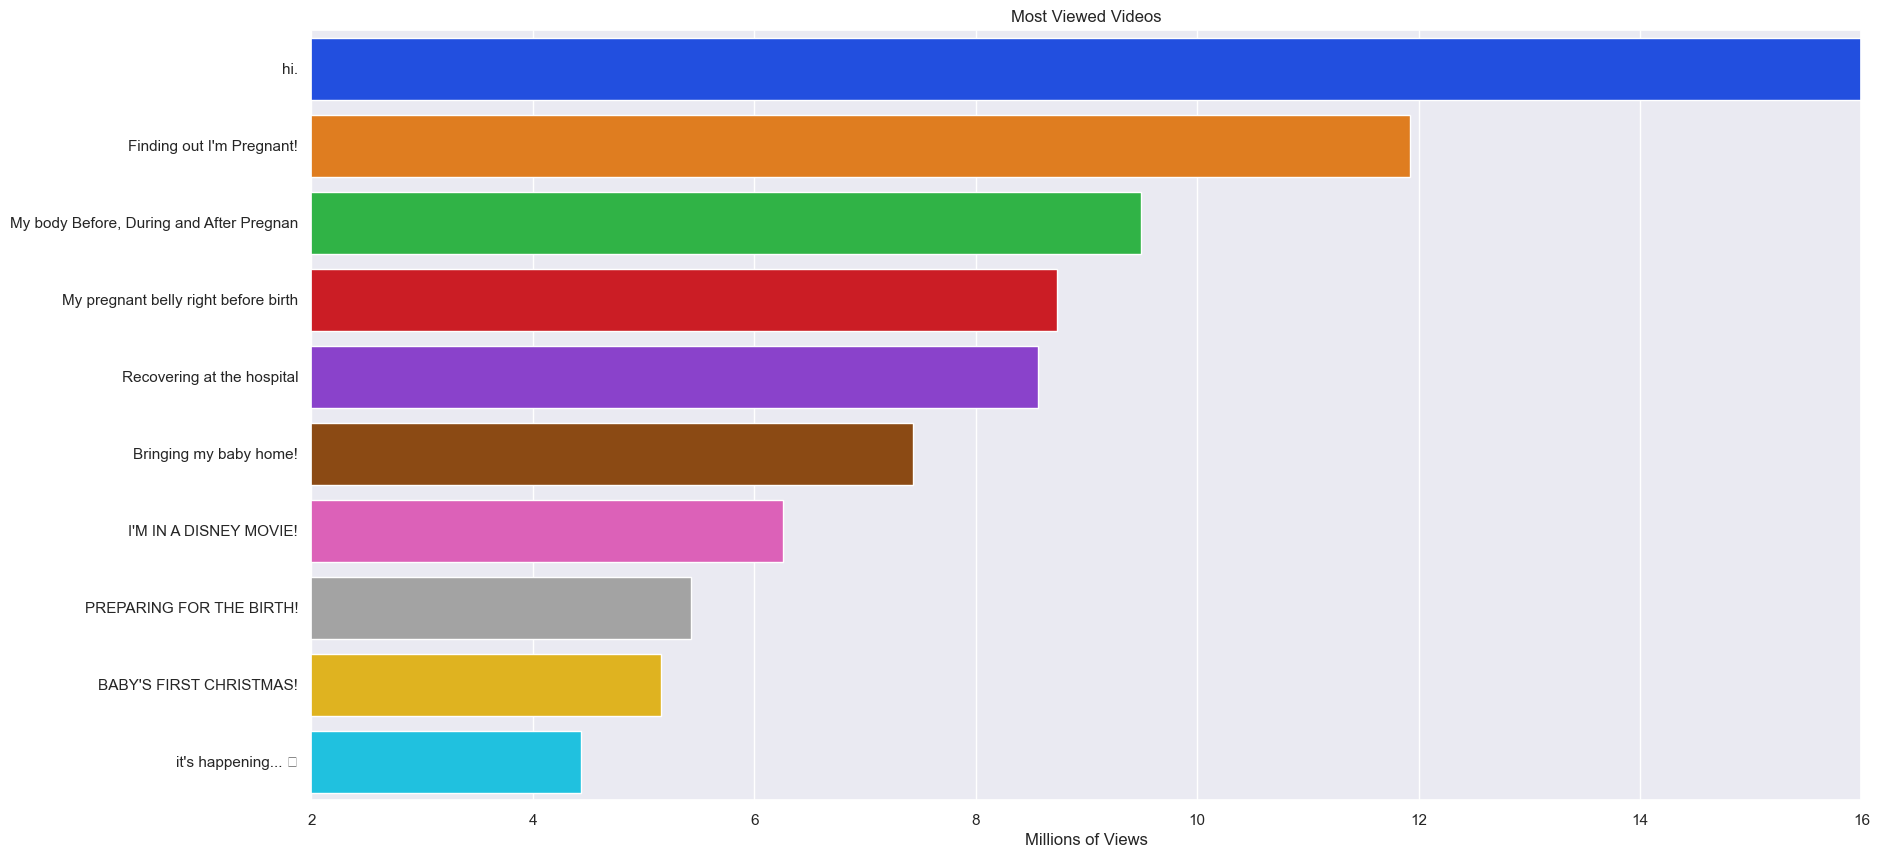

In [97]:
sns.set(rc={'figure.figsize':(20,10)})
plot = sns.barplot(x="view_count_millions", y="title", data=df_highest_views, palette="bright")
plot.set(xlabel='Millions of Views', ylabel='')
plot.set_title('Most Viewed Videos')
plt.xlim(2, 16)

The next two data frames compare and contrast the interactions that her audience brought. Her we see that her highet reactions have to deal with big news of her child, or one of her two appology videos. These have the highest reactions, however, they may not all ber perceived well.

In [84]:
# Most Interations ( Like + Dislikes + Comments)
df_highest_reactions = df.nlargest(10, 'reactions')
df_highest_reactions['title'] = df_highest_reactions['title'].str[:40]
df_highest_reactions['reactions'] = df_highest_reactions['reactions'] / 1000
df_highest_reactions

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions
1060,Recovering at the hospital,I'm obsessed with my baby. \n\nGet my new lips...,2018-12-15T02:30:43Z,24,8563642,383844,0,36409,26,456.662
1113,Finding out I'm Pregnant!,Make sure to watch the pregnancy reveal video ...,2018-06-29T20:30:00Z,22,11918830,368194,0,28347,25,424.888
1059,Bringing my baby home!,Get my new lipstick! - http://mirandasingslips...,2018-12-16T01:02:01Z,20,7433040,325202,0,22392,22,369.986
606,My Miscarriage,TW: This video is about my experience with Pre...,2021-02-08T17:00:16Z,11,3388293,234651,0,31530,14,297.711
870,addressing everything,addressing everything,2020-05-12T23:14:03Z,2,4011253,228754,0,26739,21,282.232
1055,"My body Before, During and After Pregnan",Get my new lipstick! - http://mirandasingslips...,2018-12-21T03:22:38Z,20,9493401,224513,0,15210,43,254.933
366,BRINGING MAISY HOME!!!,Check Out My Merch! - https://fanjoy.co/collec...,2021-12-21T18:00:11Z,19,3099790,194367,0,25027,22,244.421
404,What I Didn't Show You From The Twins Bi,Watch the twins' birth - https://www.youtube.c...,2021-11-11T16:00:04Z,19,3338730,174425,0,12672,46,199.769
1058,Drinking my breast milk!,Get my new lipstick! - http://mirandasingslips...,2018-12-17T05:09:39Z,20,4091817,155883,0,12983,24,181.849
20,hi.,I do not condone or support any kind of online...,2023-06-28T19:24:48Z,19,16732843,153728,0,13233,3,180.194


Her Least Interacted videos occured before her channel had the opportunity to blossom, or initially after an apology video.

In [100]:
# Least Interations ( Like + Dislikes + Comments)
df_least_reactions = df.nsmallest(10, 'reactions')
df_least_reactions['title'] = df_least_reactions['title'].str[:40]
df_least_reactions['reactions'] = df_least_reactions['reactions'] / 1000
df_least_reactions

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions
1388,BIRTHDAY LIVE STREAM!,I trust you guys more than anyone so I need to...,2016-09-11T01:31:13Z,0,0,1,0,0,21,0.001
1430,Song for Bailey Jacob and Parker!,This song is for my niece Bailey and nephews p...,2016-07-12T02:28:52Z,6,229070,0,0,106,33,0.212
1420,LAST NIGHT IN VANCOUVER! LIVE STREAM!,Subscribe to my vlogging channel! - https://ww...,2016-07-26T07:13:24Z,9,60826,3547,0,329,37,4.205
1303,the most boring live stream,I NEED YOUR HELP! \nSubscribe to my vlogging c...,2017-02-20T23:25:38Z,9,71546,3807,0,261,27,4.329
1216,Revealing all the Haters Back Off secret,Watching episode 6 of Haters Back Off together...,2017-10-11T04:06:53Z,9,89819,3582,0,421,42,4.424
1119,procrastination,Hi friends! Thanks for watching my vlog! I lov...,2018-05-29T22:13:00Z,0,79327,4060,0,269,15,4.598
0,MARSHALLS HAUL! KIDS BIRTHDAY & CHRISTMA,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-10T22:00:34Z,25,63400,4517,0,221,51,4.959
1450,SLUMBER PARTY LIVE STREAM!,HI LETS HAVE A SLUMBER PARTYYYY\n\nSubscribe t...,2016-06-19T08:13:52Z,9,81369,4015,0,532,26,5.079
1163,LIVE STREAM CHRISTMAS PARTY!,Hi friends! Thanks for watching my vlog! I lov...,2017-12-23T02:11:33Z,7,139955,4609,0,379,28,5.367
1444,I LOVE YOU! Live stream,hi! I just wanna say I love you. \n\nSubscribe...,2016-06-27T06:36:50Z,9,80142,4368,0,509,23,5.386


(40.0, 450.0)

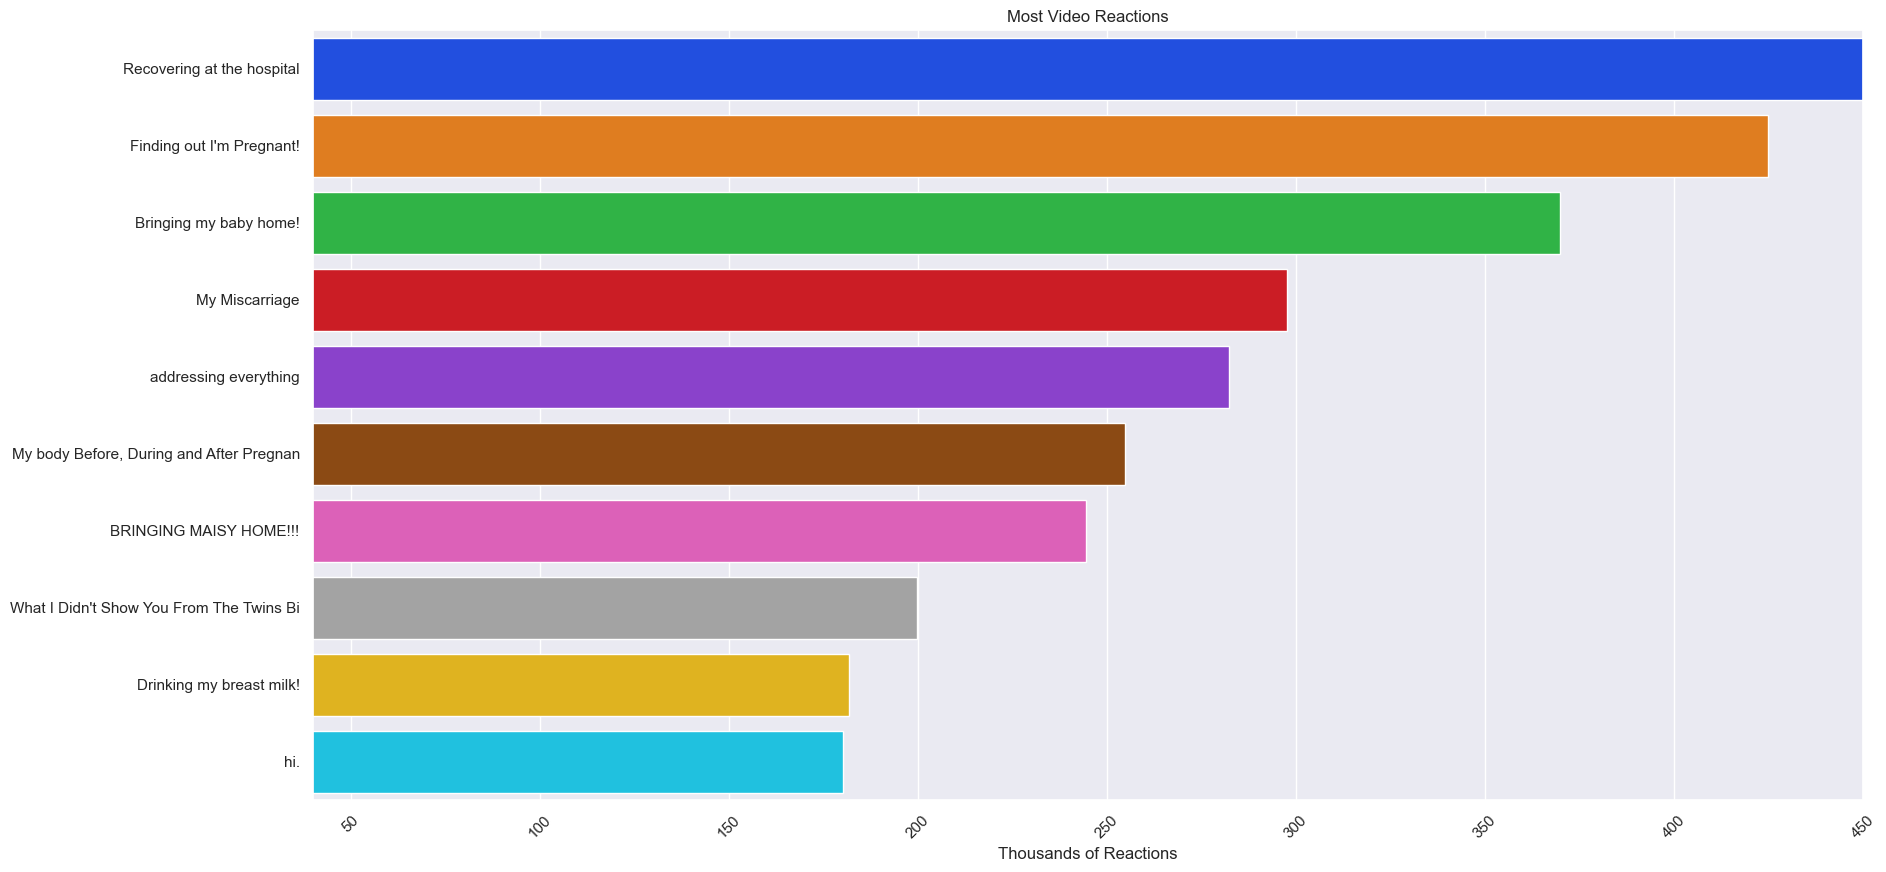

In [101]:
sns.set(rc={'figure.figsize':(20,10)})
plot = sns.barplot(y="title", x="reactions", data=df_highest_reactions, palette="bright")
plot.set(xlabel='Thousands of Reactions', ylabel='')
plt.xticks(rotation=45)
plot.set_title('Most Video Reactions')
plt.xlim(40, 450)

In [87]:
df_highest_disliked = df.nlargest(10, 'dislike_count')
df_highest_disliked['title'] = df_highest_disliked['title'].str[:40]
df_highest_disliked['dislike_count'] = df_highest_disliked['dislike_count'] / 1000
df_highest_disliked

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions
0,MARSHALLS HAUL! KIDS BIRTHDAY & CHRISTMA,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-10T22:00:34Z,25,63400,4517,0.0,221,51,4959
1,Christmas Lights & Home Renovation Plans,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-08T22:10:18Z,22,97191,5547,0.0,384,40,6315
2,TIKTOK CHAMOY PICKLE TASTE TEST!,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-07T22:12:15Z,23,92553,5894,0.0,431,32,6756
3,I GOT SO MANY COMMENTS LIKE THIS! 😩,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-07T00:10:12Z,19,120521,6727,0.0,684,35,8095
4,TAYLOR SWIFT COPIED ME!,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-05T21:54:18Z,24,95598,6036,0.0,565,23,7166
5,The Last Miranda Shows,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-04T22:37:59Z,19,167093,8026,0.0,554,22,9134
6,I FINALLY FINISHED MY ROCKS & CRYSTALS!,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-04T00:09:18Z,19,95031,6332,0.0,485,39,7302
7,My Kids Think I'm Zendaya...,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-02T22:34:58Z,26,109350,7013,0.0,583,28,8179
8,Taylor Swift Advent and Flynn's Stand Up,Donate to Colleen Ballinger's Childhood Cancer...,2023-12-01T21:22:27Z,19,113186,7675,0.0,745,48,9165
9,I'm scared... is this Poisonous? 😩,Donate to Colleen Ballinger's Childhood Cancer...,2023-11-30T21:34:19Z,23,116496,6985,0.0,793,34,8571


To conclude, cancel culture althought rampant, isn't as prominent or effective as people may think it is. It causes a temporary sharp incline for an apology video, a sharp decline in viewership right after an apology video, but slowly starts to gain viewership and traction the farther away we get from the date of cancellation.

In a further iteration, I would gather data from more sources. I would catagorize the reaoning of why they were canceled to see if people are more willing to forgive some "scandals" in comparison to others. I would also want to reasearch if frequency plays a role in cancel culture. If someone makes the same mistake more than once, then, would people forgive, or think that apologies we insincere, causing to a longer period of downtim to rebuild trust, and for people to move on.